In [1]:
%matplotlib notebook

import matplotlib as mpl
import pandas as pd
import sys
mpl.style.use('ggplot')
import matplotlib.pyplot as plt
from os.path import isfile,exists
import math
import numpy as np
import os
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
import ujson
import tensorflow as tf
from keras import backend as K
from keras import regularizers
from keras.layers import Dense, GRU, Conv1D, MaxPool1D, GlobalMaxPool1D,MaxPooling1D
from keras.models import Model, Sequential
from trainer.model import model_fn, compile_model, LOOKBACK
from keras.preprocessing.sequence import pad_sequences

/Users/joelvogt/Development/PycharmProjects/machine-learning/venv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Data exploration

In [3]:
df = pd.read_pickle('../data/evt_office_london.p')
df = pd.DataFrame(df.reset_index().groupby(['appliance']).apply(lambda x: x.iloc[-len(df[df.appliance=='tumbler']):]).values, columns=df.reset_index().columns).set_index('t')

In [4]:
def visualize_vibration(df, appliance, window):
#     pd.DataFrame(pd.DataFrame(df[df.appliance==appliance][['x','y','z']].values,columns=['x','y','z']).apply(np.square).sum(axis=1).apply(np.sqrt),columns=['magnitude']).rolling(window).mean().plot()
    pd.DataFrame(df[df.appliance==appliance][['x','y','z']].values,columns=['x','y','z']).rolling(window).mean().plot(subplots=True, title=appliance)

<IPython.core.display.Javascript object>


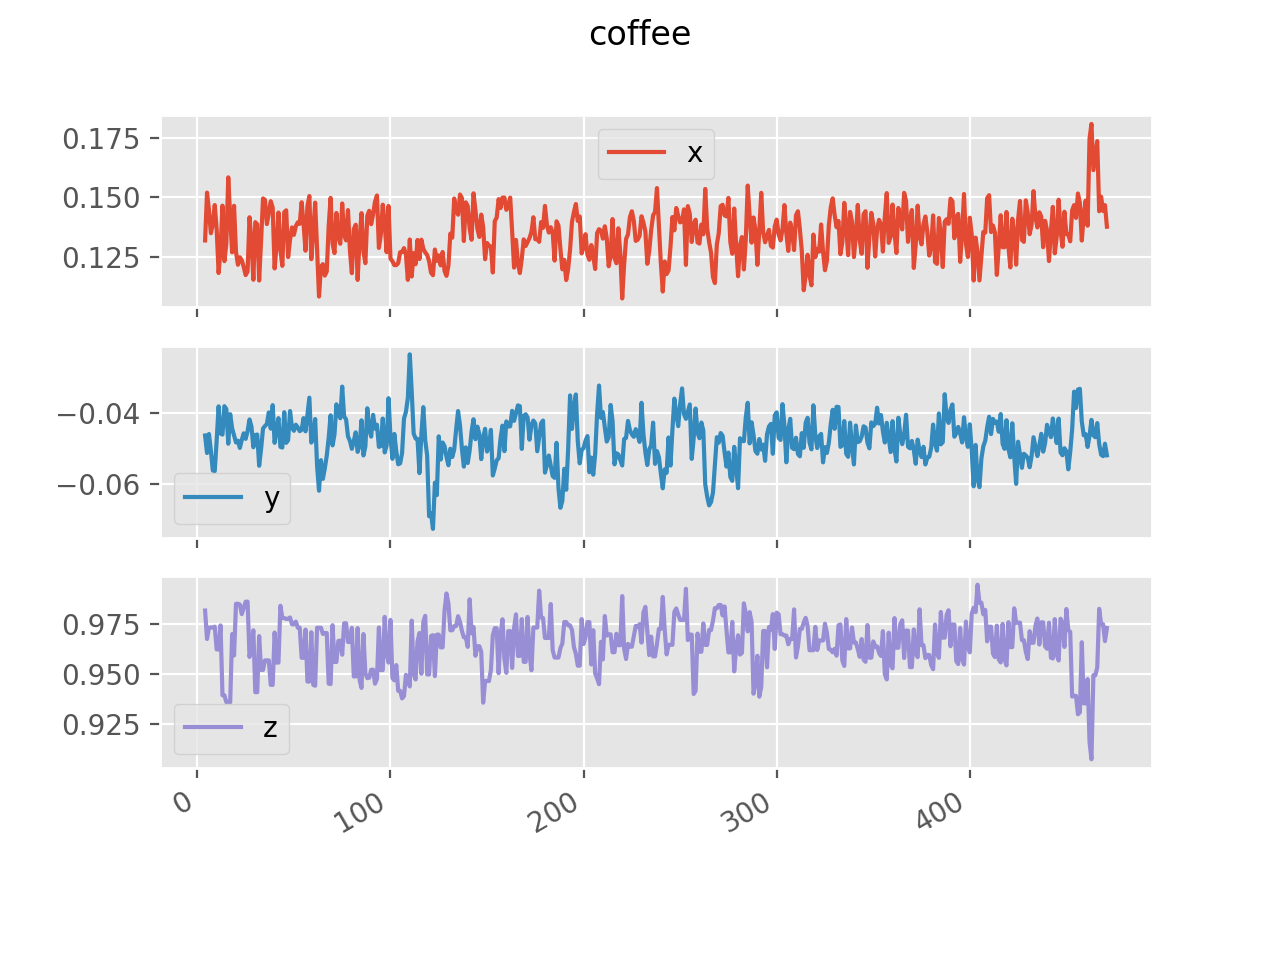

In [5]:
visualize_vibration(df, 'coffee', 5)

<IPython.core.display.Javascript object>


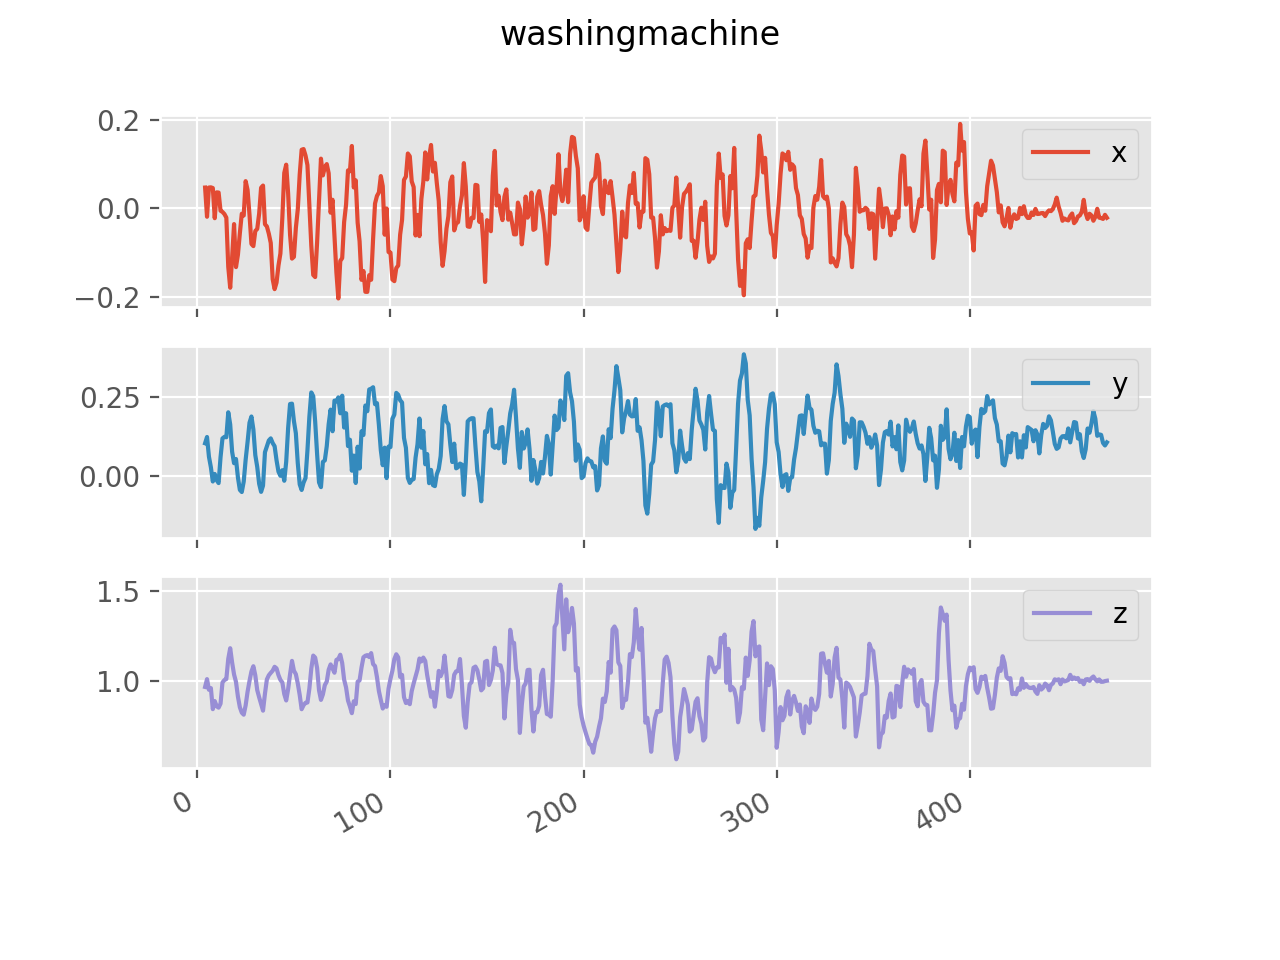

In [6]:
visualize_vibration(df, 'washingmachine', 5)

<IPython.core.display.Javascript object>


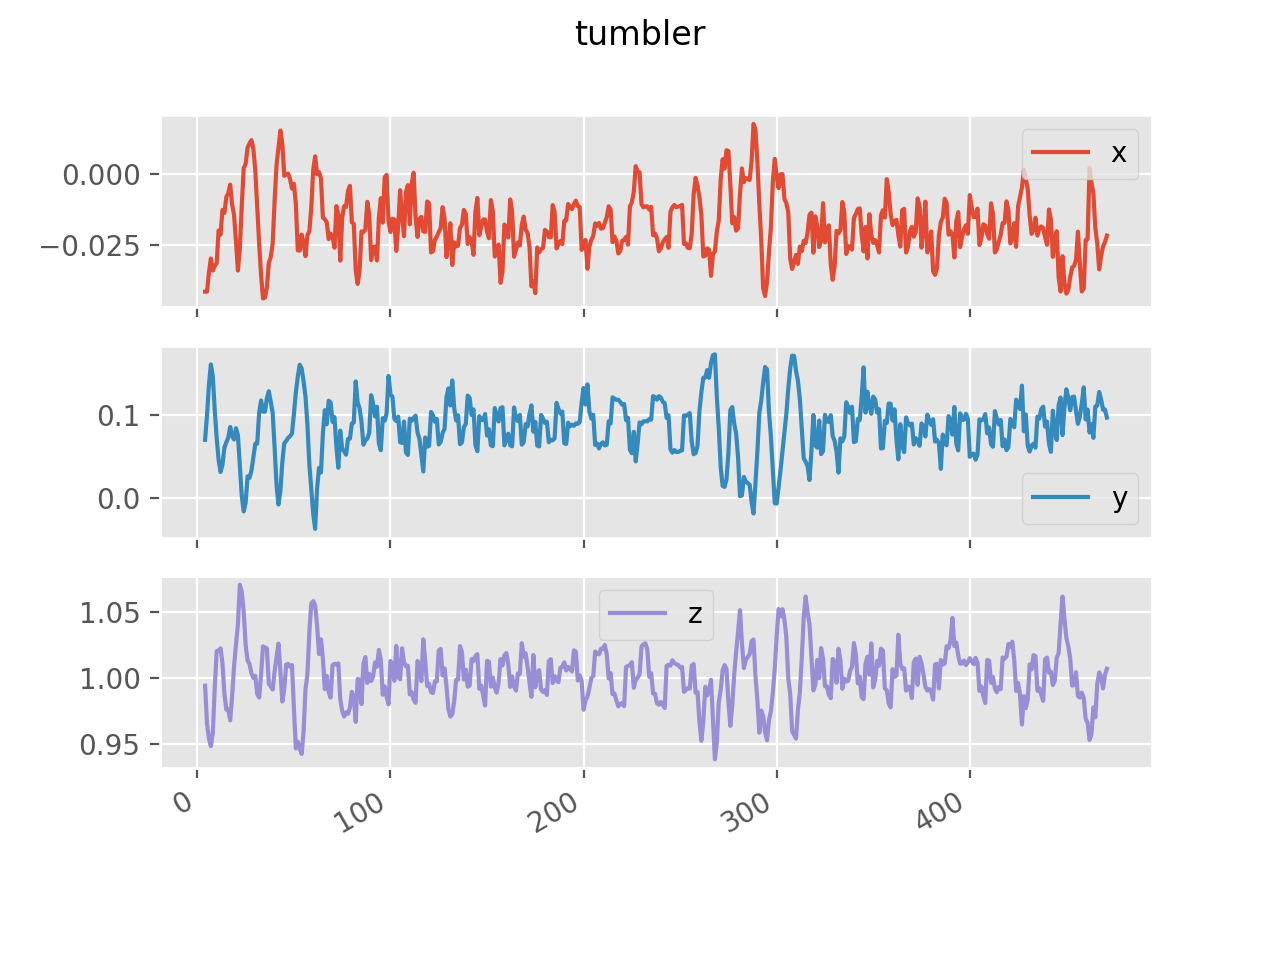

In [7]:
visualize_vibration(df, 'tumbler', 5)

In [8]:
# Data preparation

In [9]:
## Splitting the data into a training and test set

In [10]:
def window(data,label,label_dtype, lookback):
    X = np.empty(shape=(len(data) - lookback + 1,lookback,len(data[0])), dtype=np.float32)
    y = np.empty(len(X), label_dtype)
    y[:] = label
    for i in range(len(data) - lookback+1):
        X[i,:] = data[i:i+lookback]
    return X, y

In [11]:
train_x, train_y, test_x, test_y, validate_x, validate_y = [],[],[],[],[],[]
split = 0.7

label_dtype = 'U{}'.format(max(map(lambda x: len(x),df.appliance.unique())) )

for label, values in df.groupby('appliance'):
    data, labels = window(values[['x','y','z']].values, label, label_dtype, LOOKBACK)
    _train_x, _test_x = data[:int(len(data)*split)], data[int(len(data)*split):]
    _train_y, _test_y = labels[:int(len(labels)*split)],labels[int(len(labels)*split):]
    _train_x, _validate_x = _train_x[:int(len(_train_x)*split)],_train_x[int(len(_train_x)*split):]
    _train_y, _validate_y = _train_y[:int(len(_train_y)*split)],_train_y[int(len(_train_y)*split):]
    train_x.append(_train_x)
    test_x.append(_test_x)
    train_y.append(_train_y)
    test_y.append(_test_y)
    validate_x.append(_validate_x)
    validate_y.append(_validate_y)
    

train_x, train_y = np.vstack(train_x), np.concatenate(train_y) 
validate_x, validate_y = np.vstack(validate_x), np.concatenate(validate_y)
test_x, test_y = np.vstack(test_x), np.concatenate(test_y)

In [12]:
## Feature scaling

In [13]:
### Scale input data

In [14]:
stdsc = StandardScaler()
train_x = stdsc.fit_transform(np.vstack(train_x)).reshape(train_x.shape)
validate_x = stdsc.transform(np.vstack(validate_x)).reshape(validate_x.shape)
test_x = stdsc.transform(np.vstack(test_x)).reshape(test_x.shape)

In [15]:
### One-hot encoding of norminal labels

In [16]:
le = LabelEncoder()
train_y = le.fit_transform(train_y).reshape(-1,1)
validate_y = le.transform(validate_y).reshape(-1,1)
test_y = le.transform(test_y).reshape(-1,1)

In [17]:
train_y = np.array(train_y == np.arange(len(le.classes_)),dtype=float)
validate_y = np.array(validate_y == np.arange(len(le.classes_)),dtype=float)
test_y = np.array(test_y == np.arange(len(le.classes_)),dtype=float)

In [18]:
# Train and evaluate the model

In [19]:
model = model_fn(train_x.shape[1:], train_y.shape[-1])

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


In [20]:
history = model.fit(train_x, train_y, epochs=15, batch_size=32,shuffle=False,validation_data=(validate_x, validate_y),verbose=0)

<IPython.core.display.Javascript object>


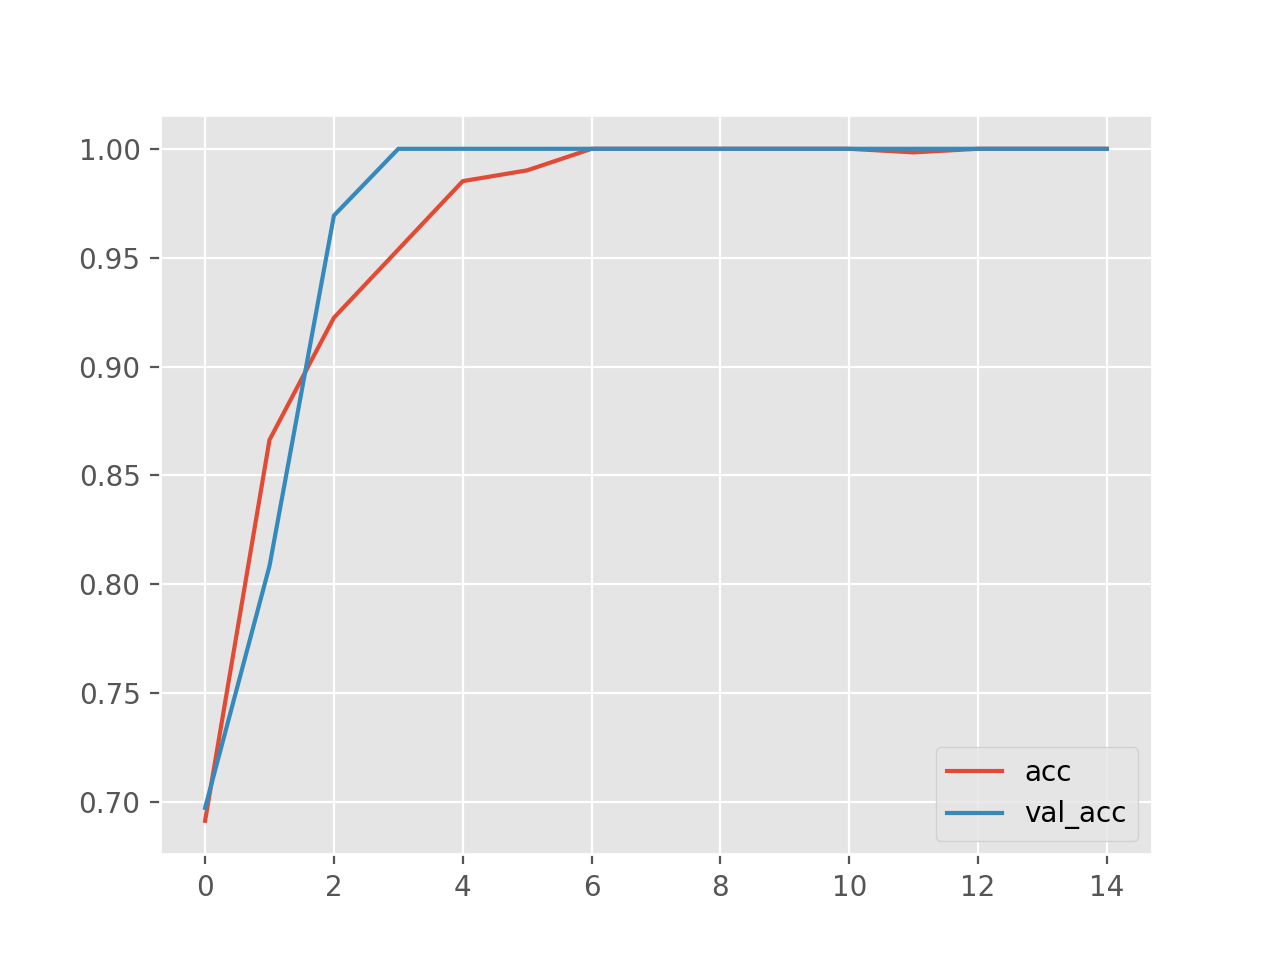

In [21]:
pd.DataFrame(history.history, columns=['acc','val_acc']).plot()

<IPython.core.display.Javascript object>


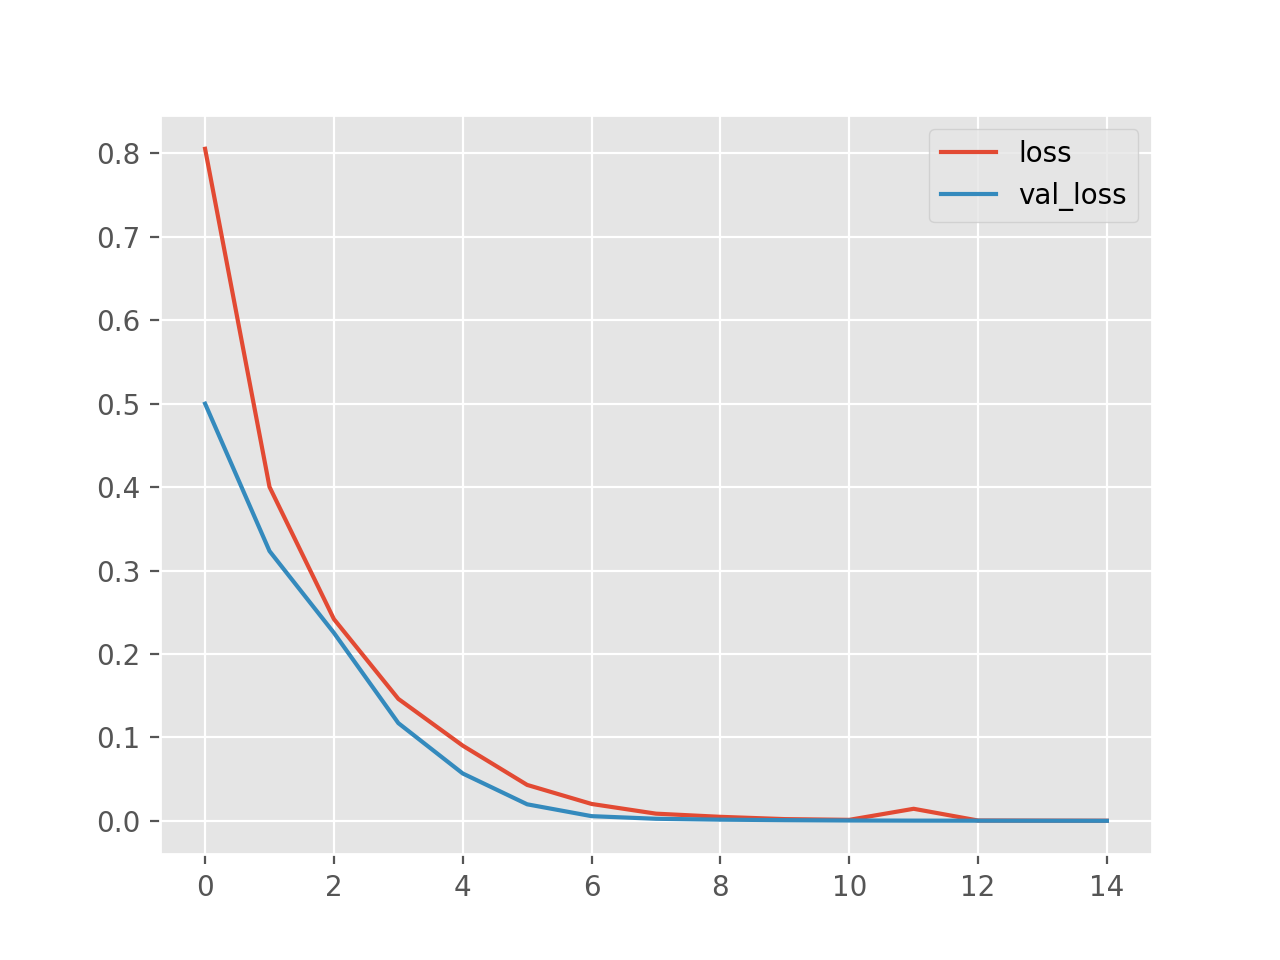

In [22]:
pd.DataFrame(history.history, columns=['loss','val_loss']).plot()

In [23]:
print(f"loss, acc {model.evaluate(test_x, test_y)}")

372/372 [==============================] - 0s 632us/step
loss, acc [0.11511501064054638, 0.9865591397849462]


In [24]:
# Export training data

In [25]:
with open('../data/train.json', 'w') as fd:
    ujson.dump((train_x.tolist(),train_y.tolist()), fd,ensure_ascii=True)

with open('../data/validate.json', 'w') as fd:
    ujson.dump((validate_x.tolist(),validate_y.tolist()), fd,ensure_ascii=True)

with open('../data/test.json', 'w') as fd:
    ujson.dump((train_x.tolist,train_y.tolist), fd,ensure_ascii=True)

In [26]:
# £xport feature params for the integration reactor script

In [27]:
with open('../reactor/input_data_params.json','w') as fd:
    ujson.dump(dict(std=stdsc.scale_.tolist(),mean=stdsc.mean_.tolist(), lookback=LOOKBACK),fd,ensure_ascii=True)

with open('../reactor/labels_encoding.json','w') as fd:
    ujson.dump(le.classes_,fd,ensure_ascii=True)

In [28]:
a = [[240.2333, 0.04467773, 0.0982666, 0.9526367], [240.3782, -0.1687012, 0.2666016, 1.100708], [240.5221, 0.002197266, 0.1547852, 0.5754395], [241.9195, -0.1931152, 0.3231201, 1.328125], [243.387, -0.1643066, -0.08337402, 1.530151], [243.5364, 0.05554199, -0.04614258, 0.72229], [243.6855, -0.1518555, 0.3288574, 1.324707], [243.8411, -0.09191895, 0.1463623, 0.6593018], [244.1654, 0.138916, -0.04943848, 1.495972], [244.3113, 0.04443359, -0.0546875, 0.8087158], [244.4542, -0.03552246, 0.230957, 1.156372], [244.5981, -0.1418457, 0.1977539, 0.8537598], [244.7425, 0.03186035, 0.1473389, 0.6385498], [244.8856, -0.1833496, 0.2646484, 1.105225], [245.0302, -0.003662109, 0.1461182, 0.5479736], [245.1745, 0.1264648, -0.05749512, 1.467896], [245.318, 0.05419922, -0.04968262, 0.817627], [245.4626, -0.04663086, 0.2424316, 1.164307], [245.6072, -0.1308594, 0.1894531, 0.8343506], [245.7502, 0.03259277, 0.1439209, 0.6551514], [245.8952, 0.1156006, -0.0871582, 1.549316], [246.0393, 0.05334473, -0.03735352, 0.7071533], [246.1834, -0.1472168, 0.3431396, 1.355103], [246.3675, 0.0736084, -0.0904541, 1.218628], [246.5124, 0.07287598, 0.02600098, 0.8284912], [246.656, -0.2033691, 0.3112793, 1.30481], [246.8012, -0.03173828, 0.130127, 0.5256348], [246.9453, 0.1247559, 0.0135498, 1.299194], [247.0886, 0.0567627, -0.07421875, 0.9958496], [247.2334, 0.03637695, 0.1043701, 0.9622803], [247.3783, -0.1799316, 0.2587891, 1.120483], [247.5217, -0.01281738, 0.1402588, 0.5303955], [247.6663, 0.1359863, -0.02978516, 1.490601], [247.8121, 0.05090332, -0.046875, 0.817627], [247.9554, -0.007568359, 0.2001953, 1.084229], [248.1004, -0.1287842, 0.2071533, 0.9099121], [248.2462, 0.05895996, 0.1381836, 0.6043701], [248.389, -0.1854248, 0.2670898, 1.175659], [248.5731, -0.06921387, 0.12146, 0.5704346], [248.7174, 0.0871582, 0.08215332, 0.9764404], [248.8616, 0.08789063, -0.09020996, 1.275269], [249.0066, 0.07897949, 0.004150391, 0.7849121], [249.1522, -0.2088623, 0.3223877, 1.351685], [249.2953, -0.03210449, 0.1257324, 0.5093994], [249.4413, 0.1265869, 0.01074219, 1.321289], [249.5855, 0.05065918, -0.07824707, 0.9641113], [249.7293, 0.02209473, 0.1572266, 0.9681396], [249.8753, -0.1809082, 0.2609863, 1.081055], [250.0196, 0.008666992, 0.1418457, 0.5405273], [250.1638, -0.2094727, -0.08447266, 1.574219], [250.3086, -0.02001953, 0.1335449, 0.515625], [250.4536, 0.1263428, -0.02734375, 1.383423], [250.5974, 0.05505371, -0.0748291, 0.9179688], [250.7823, 0.07470703, -0.01831055, 0.7480469], [250.9266, -0.2069092, 0.3468018, 1.397827], [251.0703, -0.06738281, 0.1435547, 0.5888672], [251.2164, 0.07641602, 0.1306152, 0.8105469], [251.3615, 0.1296387, -0.0904541, 1.444946], [251.5063, 0.07006836, -0.08789063, 1.00415], [251.6509, 0.06335449, -0.03417969, 0.9587402], [251.7963, -0.1481934, 0.2608643, 1.177734], [251.9394, -0.1845703, 0.2908936, 1.078613], [252.1173, 0.0949707, -0.1030273, 1.33252], [252.4695, -0.1583252, 0.3012695, 1.075806], [252.6459, 0.09765625, 0.2318115, 1.098999], [252.8234, 0.08154297, 0.170166, 1.01416], [252.9987, -0.002075195, -0.06652832, 0.6947021], [253.2476, -0.1228027, 0.2574463, 1.084229], [253.4229, 0.05944824, -0.1237793, 1.105347], [253.6004, -0.03894043, 0.2241211, 0.7032471], [253.777, -0.1506348, 0.2593994, 1.068359], [253.9546, -0.01782227, 0.2459717, 0.8144531], [254.1298, -0.1158447, 0.2879639, 0.987915], [254.3074, -0.008300781, 0.2564697, 0.9105225], [254.4843, -0.1112061, 0.2824707, 1.01355], [254.6624, -0.03076172, 0.2271729, 0.8220215], [254.838, -0.1114502, 0.1848145, 1.030518], [255.0163, -0.06445313, 0.2357178, 0.8363037], [255.1915, 0.04992676, -0.06726074, 1.177734], [255.3692, -0.1071777, 0.2044678, 1.000244], [255.5468, 0.1104736, -0.1046143, 1.023804], [255.7231, 0.09106445, -0.08068848, 1.086548], [255.9004, -0.07873535, 0.2321777, 0.8780518], [256.0759, 0.003662109, 0.1998291, 0.8588867], [256.2538, 0.02722168, -0.03051758, 1.122192], [256.4303, -0.03649902, 0.02856445, 1.0448], [256.6085, -0.001831055, 0.1990967, 0.8598633], [256.7843, 0.01843262, 0.1942139, 0.9210205], [256.9632, 0.05432129, -0.03222656, 1.106689], [257.3163, 0.06335449, 0.2580566, 0.9781494], [257.4919, -0.1118164, 0.2333984, 0.9542236], [257.8459, -0.005615234, 0.1751709, 0.8896484], [258.0938, 0.119873, -0.04650879, 1.017944], [258.4487, 0.02722168, -0.03747559, 1.158325], [258.6243, 0.1273193, -0.03662109, 0.9379883], [258.8023, -0.01855469, -0.01599121, 1.151245], [258.9776, 0.1269531, -0.01672363, 0.927124], [259.1553, 0.02197266, -0.04125977, 1.178223], [259.3311, 0.08752441, 0.02502441, 0.9515381], [259.6856, 0.0009765625, 0.1446533, 1.014282], [259.8634, -0.005004883, 0.1021729, 1.028564], [260.0402, -0.08178711, 0.1586914, 1.009033], [260.3954, 0.01184082, -0.005249023, 1.05481], [260.7494, -0.02539063, 0.1385498, 1.042725], [261.1033, -0.004394531, 0.07055664, 0.9587402], [261.2791, 0.03735352, 0.004394531, 0.9975586], [261.4576, -0.03686523, 0.1673584, 1.039795], [261.6339, -0.02722168, 0.2114258, 0.8630371], [261.8113, 0.04748535, -0.05810547, 1.089722], [261.9869, -0.02490234, 0.04272461, 0.9587402], [262.1658, -0.1099854, 0.1428223, 1.066284], [262.342, 0.07287598, -0.003662109, 1.018799], [262.5196, -0.03039551, 0.1951904, 0.9331055], [262.696, 0.05200195, 0.133667, 1.090942], [262.9459, -0.05224609, 0.1868896, 1.00769], [263.122, -0.07617188, 0.1313477, 1.07959], [263.3008, -0.03918457, 0.01611328, 1.062622], [263.4771, -0.06835938, 0.1265869, 1.074707], [263.6546, -0.05078125, 0.1807861, 1.009888], [263.831, -0.004760742, 0.07714844, 1.008667], [264.0106, 0.01342773, 0.1101074, 0.9606934], [264.1869, 0.04638672, -0.04125977, 1.072388], [264.3646, -0.06677246, 0.1801758, 0.9621582], [264.5413, 0.02856445, 0.09960938, 0.9558105], [264.7211, -0.05505371, 0.1345215, 1.073853], [264.8964, -0.01708984, 0.1032715, 0.9284668], [265.0753, 0.05419922, 0.008544922, 1.039917], [265.4299, -0.01403809, 0.1140137, 0.9545898], [265.6076, -0.05822754, 0.1905518, 0.9610596], [265.7848, 0.04150391, 0.02416992, 1.040527], [266.14, -0.02490234, 0.08740234, 1.034302], [266.4942, -0.04577637, 0.1732178, 0.9677734], [266.8492, 0.05664063, 0.06225586, 0.9926758], [267.0283, 0.04125977, 0.06298828, 0.942627], [267.2043, 0.01306152, 0.05407715, 1.003662], [267.9862, -0.04394531, 0.1531982, 0.9891357], [268.1649, -0.008911133, 0.09509277, 0.9816895], [268.3418, -0.03942871, 0.1491699, 0.9814453], [268.6974, -0.03063965, 0.09802246, 1.026855], [268.8758, -0.03344727, 0.1096191, 1.068848], [269.0523, 0.01599121, 0.08276367, 0.9683838], [269.2323, 0.002563477, 0.07897949, 1.01355], [269.4081, -0.03088379, 0.1669922, 0.9400635], [269.5862, -0.002563477, 0.06213379, 1.045288], [269.9415, 0.005737305, 0.09680176, 1.016113], [270.1204, -0.0003662109, 0.1486816, 1.022705], [270.2968, -0.02209473, 0.1004639, 1.027466], [270.4759, -0.006591797, 0.1152344, 0.9824219], [270.831, 0.03186035, 0.06799316, 0.9978027], [271.0075, -0.0402832, 0.1602783, 1.006714], [271.3634, 0.009521484, 0.06115723, 1.016846], [271.5423, -0.02087402, 0.1166992, 1.025635], [271.8983, -0.003051758, 0.1188965, 0.9688721], [272.2532, 0.01745605, 0.07043457, 0.980957], [272.4295, -0.02404785, 0.1148682, 1.042725], [272.6804, 0.006103516, 0.06591797, 1.010864], [273.3911, 0.0002441406, 0.06347656, 0.9870605]]

In [29]:
a = stdsc.transform(np.array(a)[:,1:])

In [36]:
np.argmax(model.predict(pad_sequences(a[40:,:].reshape(3,-1),maxlen=LOOKBACK).reshape(-1,3)[None,:]))

1

In [33]:
np.argmax(model.predict(pad_sequences(a.reshape(3,-1),maxlen=LOOKBACK).reshape(-1,3)[None,:]))

1

In [32]:
# pad_sequences(a[:20,:].reshape(3,-1),maxlen=100).reshape(-1,3)[None,:]